## Model Selection and Training on Train Data

### Importing Required Libraries 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
import shap

#### Importing Processed train data

In [3]:
#importing processed train data
traindata = pd.read_csv('traindata_processed.csv')
pd.set_option('display.max_columns', None)
traindata.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationName,OAuthApplicationId,FileName,ResourceIdName,OSVersion,City,Day,Year,Hour,Time
0,1709396985476,26,18583,687462,31,813,12,0,9,1,360606,160396,453297,153085,529644,1631,860,3421,881,4132,3586,66,10630,6,2024,5,21407
1,927712939180,33,5065,3990,38,25,9,0,17,0,360606,160396,453297,3142,529644,1631,860,3421,881,289573,3586,66,10630,3,2024,10,38709
2,1090921697002,201,150787,807590,419,444,6,0,17,0,360606,160396,453297,4181,529644,1631,860,3421,881,289573,3586,66,10630,13,2024,3,13000
3,1434519079555,204,108287,28575,44,1233,16,2,9,1,360606,160396,453297,153085,529644,1631,860,3421,881,97007,3586,66,10630,8,2024,16,60897
4,1005022347708,54,528202,1458226,102,58829,7,0,9,0,360606,160396,453297,153085,529644,1631,860,3421,881,39978,3586,66,10630,9,2024,2,10081


In [4]:
traindata.shape

(4577400, 27)

#### Defining features (X) and target (y)

In [5]:
X = traindata.drop(columns=['IncidentGrade','Id'])  
y = traindata['IncidentGrade']                 # Target column

In [6]:
# Stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [7]:
# Checking class distribution in training and validation sets
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("Validation set class distribution:\n", y_val.value_counts(normalize=True))

Training set class distribution:
 IncidentGrade
0    0.431237
2    0.351500
1    0.217263
Name: proportion, dtype: float64
Validation set class distribution:
 IncidentGrade
0    0.431237
2    0.351500
1    0.217263
Name: proportion, dtype: float64


## Model Selection and Training:

### Baseline Models

In [7]:
# Baseline Models
baseline_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

# Training and evaluation on validation set
for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Classification Report:\n", classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))



Training Logistic Regression...


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logistic Regression Classification Report:
               precision    recall  f1-score   support

     Class 0       0.60      0.45      0.52    592183
     Class 1       0.34      0.33      0.33    298350
     Class 2       0.52      0.69      0.60    482687

    accuracy                           0.51   1373220
   macro avg       0.49      0.49      0.48   1373220
weighted avg       0.52      0.51      0.51   1373220


Training Decision Tree...
Decision Tree Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99    592183
     Class 1       0.98      0.98      0.98    298350
     Class 2       0.99      0.99      0.99    482687

    accuracy                           0.99   1373220
   macro avg       0.99      0.99      0.99   1373220
weighted avg       0.99      0.99      0.99   1373220



### Advanced Models

In [11]:
# Advanced models
advanced_models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)}

# Additional libraries for XGBoost and LightGBM
try:
    advanced_models['XGBoost'] = XGBClassifier(scale_pos_weight=1, random_state=42,
                                                   tree_method='gpu_hist',  # Enable GPU
                                                    predictor='gpu_predictor')  # Use GPU for predictions
except ImportError:
    print("XGBoost not installed.")
    
try:
    advanced_models['LightGBM'] = LGBMClassifier(class_weight='balanced', random_state=42,device='gpu')  # Use GPU
except ImportError:
    print("LightGBM not installed.")

# Training and evaluation for advanced models
for name, model in advanced_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Classification Report:\n", classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))



Training Random Forest...
Random Forest Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.99      0.98    592183
     Class 1       0.98      0.96      0.97    298350
     Class 2       0.99      0.97      0.98    482687

    accuracy                           0.98   1373220
   macro avg       0.98      0.97      0.98   1373220
weighted avg       0.98      0.98      0.98   1373220


Training Gradient Boosting...
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

     Class 0       0.72      0.95      0.82    592183
     Class 1       0.88      0.58      0.70    298350
     Class 2       0.92      0.75      0.83    482687

    accuracy                           0.80   1373220
   macro avg       0.84      0.76      0.78   1373220
weighted avg       0.83      0.80      0.80   1373220


Training XGBoost...


[21:57:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[21:57:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "scale_pos_weight" } are not used.

[21:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[21:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgb

XGBoost Classification Report:
               precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92    592183
     Class 1       0.93      0.85      0.89    298350
     Class 2       0.95      0.91      0.93    482687

    accuracy                           0.92   1373220
   macro avg       0.92      0.91      0.91   1373220
weighted avg       0.92      0.92      0.92   1373220


Training LightGBM...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3642
[LightGBM] [Info] Number of data points in the train set: 3204180, number of used features: 25
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (36.67 MB) transferred to GPU in 0.057765 secs. 1 sparse feature groups
[LightGBM] [Info] Start training

### Model Selection

### Baseline Models:

#### Logistic Regression:
Struggles with class imbalance, leading to a low macro-F1 score (0.48).
Precision and recall vary significantly across classes, indicating that it's not well-suited for this problem.

#### Decision Tree:
Perfect scores suggest overfitting, especially given the high accuracy (0.99) on the training set. 

### Advanced Models:

#### Random Forest:
Achieves excellent macro-F1 (0.98), precision, and recall, suggesting it generalizes well. Likely robust due to ensemble averaging.

#### Gradient Boosting:
Balanced performance (macro-F1: 0.78), but lower than Random Forest and XGBoost.
 
#### XGBoost:
Best macro-F1 score (0.91) among all models.
Good balance across precision, recall, and F1 scores for all classes, indicating strong handling of class imbalance.


#### LightGBM:
Strong results (macro-F1: 0.89), slightly underperforming compared to XGBoost.
More efficient training but lower precision and recall for Class 0 compared to XGBoost.

### Based on these results, we proceed with XGBoost as the final model since it shows the best overall performance. 

### XGBoost has the best macro F1-score (0.91) with balanced performance. But we can see Class Imbalance so using SMOTE

### Taking Only 20% of the training data for computational efficeincy 


In [12]:
# Sample 20% of the training data
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [13]:
# Check the sizes
print("Original Training Data Size:", X_train.shape)
print("Sampled Training Data Size:", X_train_sample.shape)

Original Training Data Size: (3204180, 25)
Sampled Training Data Size: (640836, 25)


### SMOTE 

In [14]:
# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_sample, y_train_sample)

In [15]:
# Checking the new class distribution
print("Original class distribution:\n", y_train_sample.value_counts())
print("After SMOTE class distribution:\n", y_train_smote.value_counts())

Original class distribution:
 IncidentGrade
0    276464
2    225252
1    139120
Name: count, dtype: int64
After SMOTE class distribution:
 IncidentGrade
2    276464
0    276464
1    276464
Name: count, dtype: int64


### Training XGB model on class balanced data

In [16]:
# Training the XGBoost model
xgb = XGBClassifier(random_state=42,tree_method='hist',device='cuda')      
xgb.fit(X_train_smote, y_train_smote)

# Prediction on the validation set
y_val_pred = xgb.predict(X_val)

# Evaluate performance
print("Validation Set Classification Report (After SMOTE):")
print(classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

Validation Set Classification Report (After SMOTE):
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92    592183
     Class 1       0.83      0.90      0.86    298350
     Class 2       0.95      0.90      0.92    482687

    accuracy                           0.91   1373220
   macro avg       0.90      0.90      0.90   1373220
weighted avg       0.91      0.91      0.91   1373220



### SHAP Analysis for Feature Importance

In [16]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_val)

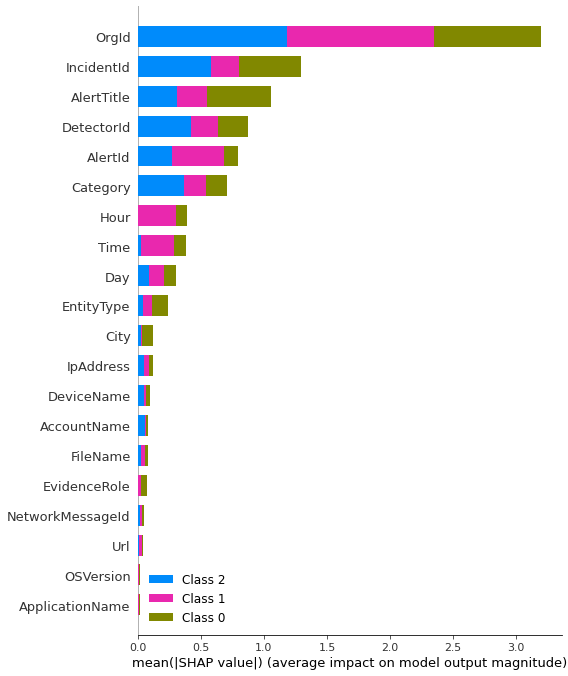

In [17]:
# Summary plot for feature importance
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns)

In [18]:
# Defining top 11 features based on SHAP
top_11_features = ['OrgId', 'IncidentId', 'AlertTitle', 'DetectorId', 
                   'AlertId', 'Category', 'Hour', 'Time', 'Day', 'EntityType', 'City']


In [19]:
# Filter datasets for top 11 features
X_train_top11 = X_train_smote[top_11_features]
X_val_top11 = X_val[top_11_features]

In [20]:
# Verify shapes
print("Shape of training set with top features:", X_train_top11.shape)
print("Shape of validation set with top features:", X_val_top11.shape)

Shape of training set with top features: (829392, 11)
Shape of validation set with top features: (1373220, 11)


### Training XGB with only top 11 features

In [22]:
# Train the XGBoost model with top features
xgb_top11 = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb_top11.fit(X_train_top11, y_train_smote)

# Predict on the validation set
y_val_pred_top11 = xgb_top11.predict(X_val_top11)

# Evaluate performance

print("Validation Set Classification Report (Top 11 Features):")
print(classification_report(y_val, y_val_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))


Validation Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92    592183
     Class 1       0.84      0.90      0.87    298350
     Class 2       0.95      0.91      0.93    482687

    accuracy                           0.91   1373220
   macro avg       0.90      0.91      0.90   1373220
weighted avg       0.91      0.91      0.91   1373220



#### we absorve that the model with 11 features was computationally efficient and produces better scores than model  with all features

## Hyperparameter Tuning

In [23]:
# Define hyperparameter grid
param_distributions = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2, 3]  # To address class imbalance further
}

# Randomized search with GPU support
random_search_top11 = RandomizedSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        tree_method='hist',  # Enable GPU support
        device='cuda'  # Use GPU for predictions
    ),
    param_distributions=param_distributions,
    scoring='f1_macro',  # Scoring metric
    cv=3,
    n_iter=20,  # Number of random combinations
    verbose=1,
    n_jobs=-1  # Parallel processing
)

# Perform hyperparameter tuning
random_search_top11.fit(X_train_top11, y_train_smote)

# Get the best model
best_xgb_top11 = random_search_top11.best_estimator_
print("Best Parameters:", random_search_top11.best_params_)

# Evaluate on validation set
y_val_pred_best_top11 = best_xgb_top11.predict(X_val_top11)
print("Validation Set Classification Report (Tuned Top 11 Features):")
print(classification_report(y_val, y_val_pred_best_top11, target_names=['Class 0', 'Class 1', 'Class 2']))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[22:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.



Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Validation Set Classification Report (Tuned Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.94      0.94      0.94    592183
     Class 1       0.88      0.92      0.90    298350
     Class 2       0.96      0.93      0.94    482687

    accuracy                           0.93   1373220
   macro avg       0.93      0.93      0.93   1373220
weighted avg       0.93      0.93      0.93   1373220



### The hyperparameter tuned model gives best scores. Saving the model.

In [24]:
import joblib

# Save the model
joblib.dump(best_xgb_top11, 'best_xgboost_Classification_model_SMOTE.pkl')
print("Model saved as best_xgboost_Classification_model_SMOTE.pkl")

Model saved as best_xgboost_Classification_model_SMOTE.pkl


## Final Evaluation on Test Set

In [25]:
# Loading test data
test_data = pd.read_csv('testdata_processed.csv')
test_data.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationName,OAuthApplicationId,FileName,ResourceIdName,OSVersion,City,Day,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,11,0,28,0,360606,160396,863,153085,529644,1631,860,3421,881,289573,3586,66,10630,4,2024,22,82520
1,1400159342154,3,91158,632273,2,2,1,0,15,0,360606,160396,453297,2833,529644,1631,860,3421,881,289573,3586,0,10630,3,2024,12,46649
2,1279900255923,145,32247,131719,2932,10807,11,0,23,1,360606,160396,453297,153085,529644,1631,860,3421,881,14,3586,66,10630,8,2024,3,12037
3,60129547292,222,15294,917686,0,0,10,1,7,1,360606,160396,453297,153085,529644,1631,860,3421,881,289573,3586,66,10630,12,2024,12,43594
4,515396080539,363,7615,5944,27,18,5,0,28,0,360606,160396,136104,153085,529644,1631,860,3421,881,289573,3586,66,10630,6,2024,17,63665


In [26]:
# Selecting only top 11 features and setting features and target
X_test_top11 = test_data[top_11_features] 
y_test = test_data['IncidentGrade']

In [27]:
# Predicting on the test set using the best model
y_test_pred_top11 = best_xgb_top11.predict(X_test_top11)

# Evaluate performance on test data
print("Test Set Classification Report (Top 11 Features):")
print(classification_report(y_test, y_test_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Test Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.94      0.82      0.88   1752895
     Class 1       0.72      0.92      0.81    902664
     Class 2       0.92      0.90      0.91   1492329

    accuracy                           0.87   4147888
   macro avg       0.86      0.88      0.87   4147888
weighted avg       0.89      0.87      0.87   4147888



# Without Using Smote 

In [28]:
# Train the XGBoost model
xgb = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb.fit(X_train_sample, y_train_sample)

# Predict on the validation set
y_val_pred = xgb.predict(X_val)

# Evaluate performance
print("Validation Set Classification Report without smote:")
print(classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

Validation Set Classification Report without smote:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92    592183
     Class 1       0.93      0.85      0.89    298350
     Class 2       0.95      0.91      0.93    482687

    accuracy                           0.92   1373220
   macro avg       0.92      0.91      0.91   1373220
weighted avg       0.92      0.92      0.92   1373220



In [29]:
# Define top 11 features based on SHAP
top_11_features = ['OrgId', 'IncidentId', 'AlertTitle', 'DetectorId', 
                   'AlertId', 'Category', 'Hour', 'Time', 'Day', 'EntityType', 'City']

# Filter datasets for top 11 features
X_train_sample_top11 = X_train_sample[top_11_features]
X_val_top11 = X_val[top_11_features]

# Verify shapes
print("Shape of training set with top features:", X_train_sample_top11.shape)
print("Shape of validation set with top features:", X_val_top11.shape)

Shape of training set with top features: (640836, 11)
Shape of validation set with top features: (1373220, 11)


### Training XGB with only top 11 features on original dataset

In [30]:
# Train the XGBoost model with top features
xgb_top11 = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb_top11.fit(X_train_sample_top11, y_train_sample)

# Predict on the validation set
y_val_pred_top11 = xgb_top11.predict(X_val_top11)

# Evaluate performance

print("Validation Set Classification Report (Top 11 Features):")
print(classification_report(y_val, y_val_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Validation Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.90      0.96      0.93    592183
     Class 1       0.93      0.87      0.90    298350
     Class 2       0.95      0.92      0.93    482687

    accuracy                           0.92   1373220
   macro avg       0.93      0.91      0.92   1373220
weighted avg       0.93      0.92      0.92   1373220



### Hyperparameter Tuning 

In [31]:
# Define hyperparameter grid
param_distributions = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2, 3]  # To address class imbalance further
}

# Randomized search
random_search_top11 = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42,
                            tree_method='hist',  # Enable GPU support
                            device='cuda'  # Use GPU for predictions
                           ),
    param_distributions=param_distributions,
    scoring='f1_macro',
    cv=3,
    n_iter=20,  # Number of random combinations
    verbose=1,
    n_jobs=-1
)

# Perform hyperparameter tuning
random_search_top11.fit(X_train_sample_top11, y_train_sample)

# Get the best model
best_xgb_top11 = random_search_top11.best_estimator_
print("Best Parameters:", random_search_top11.best_params_)

# Evaluate on validation set
y_val_pred_best_top11 = best_xgb_top11.predict(X_val_top11)
print("Validation Set Classification Report (Tuned Top 11 Features):")
print(classification_report(y_val, y_val_pred_best_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[22:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.



Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 3, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Validation Set Classification Report (Tuned Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.92      0.96      0.94    592183
     Class 1       0.94      0.88      0.91    298350
     Class 2       0.95      0.93      0.94    482687

    accuracy                           0.93   1373220
   macro avg       0.94      0.92      0.93   1373220
weighted avg       0.93      0.93      0.93   1373220



In [32]:
import joblib

# Save the model
joblib.dump(best_xgb_top11, 'best_XGB_Classification_model_without_SMOTE.pkl')
print("Model saved as best_XGB_Classification_model_without_SMOTE.pkl")

Model saved as best_XGB_Classification_model_without_SMOTE.pkl


## Final Evaluation on Test Set

In [33]:
# Predict on the test set
y_test_pred_top11 = best_xgb_top11.predict(X_test_top11)

# Evaluate performance on test data
print("Test Set Classification Report (Top 11 Features):")
print(classification_report(y_test, y_test_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Test Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.89      0.93      0.91   1752895
     Class 1       0.89      0.84      0.86    902664
     Class 2       0.93      0.91      0.92   1492329

    accuracy                           0.90   4147888
   macro avg       0.90      0.89      0.90   4147888
weighted avg       0.90      0.90      0.90   4147888

